<a href="https://colab.research.google.com/github/SwayamParida/handwritten-math-exp-recognition/blob/master/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [1]:
import os
from collections import defaultdict
from PIL import Image
from skimage import feature
from sklearn import linear_model, model_selection, preprocessing
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim, utils
from torchvision import models, transforms

plt.rcParams['image.interpolation'] = 'nearest'
%matplotlib inline

## Atomic Symbol Dataset

The atomic symbol dataset is contained in the directory referenced by the relative filepath stored in `ATOMIC_SYMBOL_DATASET_DIR`. The dataset contains a subdirectory per math symbol with the directory name corresponding to the symbol name. Each subdirectory contains JPG images of the handwritten symbols that serve as training examples for that symbol class.

In [ ]:
%cd drive/My\ Drive/cs231n/project/
!unzip -n data/data.zip -d data/handwritten-symbols

In [2]:
ATOMIC_SYMBOL_DATASET_DIR = 'Data/Atomic-Handwritten-Math-Symbols'

In [3]:
def print_progress(i, num_items):
  progress = '%.2f' % (i / num_items * 100)
  progress = f'{progress}% done.'
  progress = ('\b' * len(progress)) + progress
  print(progress, end='')

In [21]:
class AtomicSymbolDataset(utils.data.Dataset):
  def __init__(self, root_dir, max_examples_per_class=None, transform=None):
    self.root_dir = root_dir
    self.max_examples_per_class = max_examples_per_class
    self.transform = transform
    self.size = 0
    self.build_dataset_info()
    self.num_classes = len(self.symbols)
    self.label_encoder = preprocessing.LabelEncoder()
    self.label_encoder.fit(list(self.symbols.keys()))

  def build_dataset_info(self):
    self.symbols = defaultdict(list)
    for i, d in enumerate(os.listdir(self.root_dir)):
      symbol_dir = os.path.join(self.root_dir, d)
      if not os.path.isdir(symbol_dir): continue
      for j, f in enumerate(os.listdir(symbol_dir)):
        if not '.jpg' in f: continue
        if j >= self.max_examples_per_class: break
        self.symbols[d].append(os.path.join(symbol_dir, f))
#       print_progress(i, len(os.listdir(self.root_dir)))
      self.size += len(self.symbols[d])
  
  def __getitem__(self, idx):
    for symbol, imgs in self.symbols.items():
      if idx < len(imgs):
        img = Image.open(imgs[idx]).convert('RGB')
        if self.transform is not None:
          img = self.transform(img)
        return (img, self.label_encoder.transform([symbol])[0])
      else:
        idx -= len(imgs)
    raise IndexError('Index out of bounds')
  
  def __len__(self):
    return self.size

In [12]:
symbol_dataset = AtomicSymbolDataset(ATOMIC_SYMBOL_DATASET_DIR, 1000)

Getting a feel for the dataset

Symbol: ['leq']
Image dimensions: (45, 45)


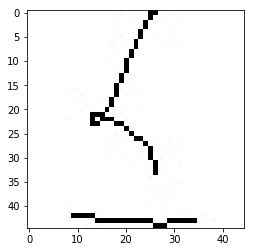

In [14]:
random_index = np.random.choice(len(symbol_dataset))
sample_img, sample_img_label = symbol_dataset[random_index]
sample_img_label = symbol_dataset.label_encoder.inverse_transform(sample_img_label)
_ = plt.imshow(sample_img, cmap='Greys_r')
print(f'Symbol: {sample_img_label}')
print(f'Image dimensions: {sample_img.size}')

In [15]:
print(f'Number of examples: {len(symbol_dataset)}')
# print(f'Number of training examples: {X_train.shape[0]}')
# print(f'Number of testing examples: {X_test.shape[0]}')
print(f'Number of classes: {symbol_dataset.num_classes}')

Number of examples: 67583
Number of classes: 82


# Baseline 1 - Symbol Segmentation and Atomic Classification

To establish a baseline for the classification task, we shall develop a rudimentary model that segments each image of a mathematical expression into individual symbols and then feed these symbols to a Softmax classifer that has been trained on the atomic symbols dataset.

Segmenting expressions into individual symbols

In [ ]:
def featurize(X, featurizers=None):
  X_feat = []
  for ex in X:
    if featurizers is None:
      x = np.ndarray.flatten(ex)
    else:
      x = np.concatenate([np.ndarray.flatten(featurizer(ex)) for featurizer in featurizers])
    X_feat.append(x)
  return np.array(X_feat)

Converting PyTorch Dataset object into 2D Numpy array

In [ ]:
X = np.empty(shape=(len(symbol_dataset), *symbol_dataset[0][0].shape))
y = np.empty(shape=len(symbol_dataset), dtype=np.str)

progress = str()
for i in range(len(symbol_dataset)):
  X[i], y[i] = symbol_dataset[i]
  if i % 20 == 0: print_progress(i, len(symbol_dataset))

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.25)

Training a Softmax classifier on the raw pixels of the atomic symbols dataset

In [ ]:
softmax_classifier = linear_model.LogisticRegression()
X_train_feat = featurize(X_train)
softmax_classifier.fit(X_train_feat, y_train)

train_acc = softmax_classifier.score(X_train_feat, y_train)
test_acc = softmax_classifier.score(featurize(X_test), y_test)
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Training the classifier with DAISY feature descriptors instead of raw pixels

In [ ]:
X_train_feat = featurize(X_train, [feature.daisy])
softmax_classifier.fit(featurize(X_train_feat), y_train)

train_acc = softmax_classifier.score(X_train_feat, y_train)
test_acc = softmax_classifier.score(featurize(X_test, [feature.daisy]), y_test)
print(f'Train accuracy: {train_acc}')
print(f'Test accuracy: {test_acc}')

Using AlexNet as a feature extractor

In [16]:
model_ft = models.alexnet(pretrained=True)

for param in model_ft.parameters():
  param.requires_grad = False
num_features = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_features, symbol_dataset.num_classes)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ft = model_ft.to(device)

print(model_ft)

params_to_update = [param for param in model_ft.parameters() if param.requires_grad]
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
loss_func = nn.CrossEntropyLoss()

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Perform image transformations so that dataset images fit AlexNet configurations

In [17]:
tsfm = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
])

In [22]:
test_train_split = [0.8, 0.2]
assert(np.sum(test_train_split) == 1.0)

symbol_dataset = AtomicSymbolDataset(ATOMIC_SYMBOL_DATASET_DIR, 100, tsfm)

split_lengths = np.round(np.multiply(test_train_split, len(symbol_dataset)))
split_lengths = split_lengths.astype(int)
assert(np.sum(split_lengths) == len(symbol_dataset))

train_set, test_set = utils.data.random_split(symbol_dataset, split_lengths)
train_loader = utils.data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
test_loader = utils.data.DataLoader(test_set, batch_size=4, shuffle=True, num_workers=2)

In [26]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer_ft.zero_grad()

        # forward + backward + optimize
        outputs = model_ft(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer_ft.step()

        # print statistics
        running_loss += loss.item()
        if i % 250 == 249:    # print every 250 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 250))
            running_loss = 0.0

print('Finished Training')

[1,   250] loss: 4.212
[1,   500] loss: 3.677
[1,   750] loss: 3.704
[1,  1000] loss: 3.729


KeyboardInterrupt: 